# Regression of Forward Returns vs Log(CAPE) - Overlapping and Non-overlapping Periods
In this notebook, we explore the relationship between the starting CAPE (Cyclically Adjusted Price-to-Earnings) and subsequent 5-year forward returns in the Indian market. The analysis relies on publicly available data.
        
**Why does this matter?** CAPE is often used by long-term investors and researchers to gauge whether the market is under- or over-valued. By examining how the log of CAPE correlates with actual future returns, we gain a better understanding of how starting valuations may relate to subsequent performance.

In the sections that follow, we will:
1. Load necessary Python libraries.
2. Load the Indian CAPE dataset from [India CAPE (Cyclically Adjusted P/E)](https://capeindia.iima.ac.in/)
3. Load the Fama-French 6 factors dataset using the `IndiaFactorLibrary` python library that accesses Invespar's ["Data Library: Fama-French Factors, Momentum, and Low-Risk Factors for the Indian Market"](http://invespar.com/research)
4. Merge these datasets on a common timeline.
5. Calculate forward 5-year annualised returns.
6. Regress these forward returns against the log of CAPE.
7. Visualise the results.
        
Let us begin!

In [ ]:
# Install required libraries (this is only necessary 
# if running in an environment that does not automatically handle 
# requirements.txt)
!pip install indiafactorlibrary


## Step 1: Import Required Libraries
We start by importing the necessary libraries for data processing, regression analysis, and visualisation.

In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from indiafactorlibrary import IndiaFactorLibrary

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


## Step 2: Load the India CAPE Dataset
We load the CAPE dataset from the capeindia.iima.ac.in url.

In [20]:
url1 = 'https://capeindia.iima.ac.in/files/india_cape.csv'
capeindia = pd.read_csv(url1, index_col=['Date'], parse_dates=['Date'])
print("Cape India Dataset:")
print(capeindia.tail())

Cape India Dataset:
            BSE Sensex CAPE 10  BSE Sensex CAPE 7  BSE Sensex CAPE 5  \
Date                                                                   
2024-08-31               36.29              35.34              33.67   
2024-09-30               37.21              36.11              34.30   
2024-10-31               35.78              34.60              32.75   
2024-11-30               34.74              33.47              31.58   
2024-12-31               34.97              33.57              31.57   

            NIFTY 500 CAPE 10  NIFTY 500 CAPE 7  NIFTY 500 CAPE 5  
Date                                                               
2024-08-31              44.95             42.32             38.58  
2024-09-30              45.99             43.16             39.21  
2024-10-31              44.03             41.18             37.29  
2024-11-30              42.14             39.28             35.48  
2024-12-31              42.60             39.56             35.64  

## Step 3: Load the Invespar Factor Dataset Using IndiaFactorLibrary
We use the `IndiaFactorLibrary` to load the Fama-French 6 factors dataset, which includes the market returns needed to compute forward returns.

In [21]:
ifl = IndiaFactorLibrary()
ff6 = ifl.read('ff6')[0]  # Reading Fama-French 6 factors dataset
print("India FF6 Dataset:")
print(ff6.tail())

India FF6 Dataset:
                MF    SMB5     HML     RMW     CMA     WML      RF     MKT
Dates                                                                     
2024-08-31 -0.2267  1.9443 -0.5938  1.3217 -0.7434 -1.1716  0.5528  0.3261
2024-09-30  0.9313 -0.0897 -0.9723 -0.2425 -1.6209 -2.5116  0.5528  1.4841
2024-10-31 -7.1739  4.2714 -0.3687  0.4296 -0.4976  0.8557  0.5640 -6.6099
2024-11-30 -0.8015  1.3382  0.6760  0.7256  0.7858  1.5223  0.4870 -0.3145
2024-12-31 -2.1594  1.7049 -0.6544  0.3163 -1.2546  1.6039  0.5388 -1.6206


## Step 4: Merge the Datasets

In order to align our CAPE data with market returns, we merge the data on their respective dates. We focus on two columns:
- The CAPE values (We choose thr `NIFTY 500 CAPE 10`),
- The market (`MKT`) factor returns from the Fama-French dataset,

After merging, we store them in a single `DataFrame`.

In [22]:
merged_df = pd.concat([
    capeindia['NIFTY 500 CAPE 10'].dropna().squeeze().to_frame('cape'),
    ff6['MKT']
], axis=1)

print("Merged Dataset:")
print(merged_df.tail())

Merged Dataset:
             cape     MKT
2024-08-31  44.95  0.3261
2024-09-30  45.99  1.4841
2024-10-31  44.03 -6.6099
2024-11-30  42.14 -0.3145
2024-12-31  42.60 -1.6206


## Step 5: Prepare Market Index and Calculate Forward 5-Year Returns
We calculate the forward 5-year annualised returns based on the market index that we derive from the Market returns.

Using the monthly `MKT` returns, we construct a hypothetical market index by cumulatively multiplying the returns. Then, we compute the forward 5-year annualized return by taking the ratio of the index level 60 months later (i.e., 5 years later, assuming monthly data) to the current index level, raising it to the power of (1/5), and subtracting 1.

In other words:

$$ \text{5-year forward return} = \left(\frac{\text{Index}_{(t+60)}}{\text{Index}_{t}}\right)^{\frac{1}{5}} - 1 $$
      ]

In [23]:
merged_df['market_index'] = (1 + merged_df['MKT'] / 100).cumprod()
merged_df['5y_forward_return'] = (
    merged_df['market_index'].shift(-60) / merged_df['market_index']
).pow(1/5) - 1

## Step 6: Log Transform CAPE
Next, we convert the CAPE value to its natural logarithm. Empirical studies often log-transform valuation metrics to achieve better linearity when doing regression analysis."
      ]

In [24]:
merged_df['log_cape'] = np.log(merged_df['cape'])

## Step 7: Prepare Data for Regression
We focus our analysis on the columns needed for our model: `log_cape` and `5y_forward_return`. We also drop any rows with missing values to ensure a clean dataset for regression.
      ]

In [25]:
regression_df = merged_df[['log_cape', '5y_forward_return']].dropna()

## Step 8: Perform Regression
We regress the forward 5-year returns on the log of CAPE.
We set up a simple linear regression model:
$$ \text{5y forward return} = \beta_0 + \beta_1 * \ln(\text{CAPE}) + \epsilon $$

We then fit the data to estimate $\beta_0$ (intercept) and $\beta_1$ (slope).

In [26]:
X = regression_df[['log_cape']]
y = regression_df['5y_forward_return']

model = LinearRegression()
model.fit(X, y)

print(f"Regression Coefficient: {model.coef_[0]:.2f}")
print(f"Regression Intercept: {model.intercept_:.2f}")

Regression Coefficient: -0.13
Regression Intercept: 0.53


#### Goodness of Fit $R^2$ and its interpretation

The coefficient of determination $ R^2 for our regression indicates how well forward returns are explained by intial CAPE. Most empirical studies have shown a low explanatory power, making initial CAPE an indicator of future returns, but not a robust predictor of future returns. While starting valuations have some explanatory power, other factors and market dynamics also play significant roles in determining future returns. 

It is important to note that $R^2$ alone does not confirm the correctness of a model or imply causality; rather, it gives a sense of how well the chosen independent variable(s) collectively explain the variation in the dependent variable. As more data is collected or different model specifications are tested, the $ R^2 $ value may change, highlighting the evolving nature of market conditions and the importance of considering multiple explanatory factors in quantitative finance research.

In [27]:
# Calculate R^2 of the regression
r2 = model.score(X, y)
print(f"{r2:.3f}")

0.357


## Step 9: Plot the Results

Finally, we visualise the scatter of (log(CAPE), forward returns) along with the fitted regression line. We also include a vertical line indicating the most *current* log(CAPE) value to show where the market stands based on the latest data.

The y-axis is converted to percentage terms for better readability.

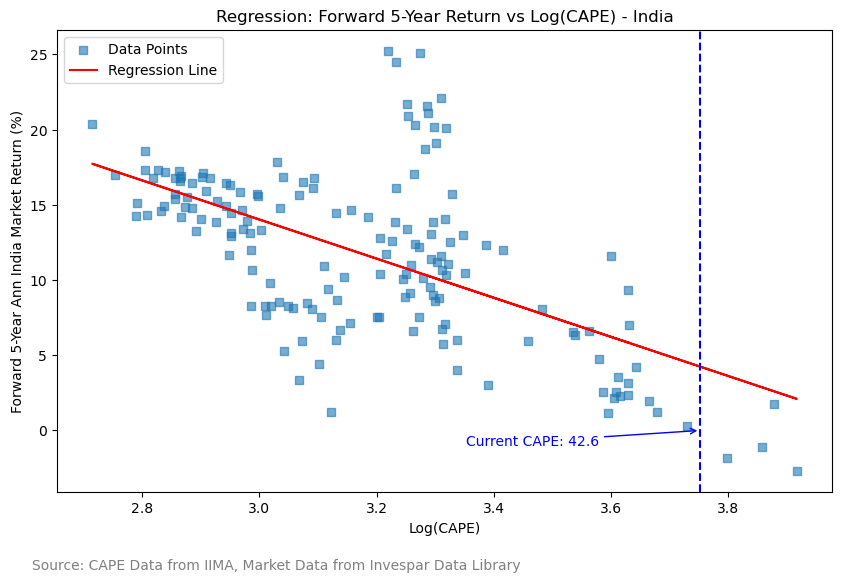

In [28]:
# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot with square markers
ax.scatter(X, y * 100, alpha=0.6, label='Data Points', marker='s')

# Regression line
ax.plot(X, model.predict(X) * 100, color='red', label='Regression Line')

# Highlight current CAPE level
current_log_cape = np.log(merged_df['cape'].dropna().iloc[-1])
ax.axvline(x=current_log_cape, color='blue', linestyle='--')

# Annotate current CAPE level
ax.annotate(
    f"Current CAPE: {merged_df['cape'].dropna().iloc[-1]:.1f}", 
    xy=(current_log_cape, 0), 
    xytext=(current_log_cape -.4, -1), 
    arrowprops=dict(arrowstyle="->", color='blue'),
    fontsize=10,
    color='blue'
)

# Add labels, title, and legend
ax.set_xlabel('Log(CAPE)')
ax.set_ylabel('Forward 5-Year Ann India Market Return (%)')
ax.set_title('Regression: Forward 5-Year Return vs Log(CAPE) - India')
ax.legend()

# Add source annotation
source_text = "Source: CAPE Data from IIMA, Market Data from Invespar Data Library"
fig.text(0.1, -0.02, source_text, fontsize=10, color='gray')

# Show plot
plt.show()


## Non-Overlapping Analysis

In addition to the foundational analysis conducted earlier, this section introduces **non-overlapping analysis** as a methodological approach to examine the relationship between valuation metrics and market returns. Non-overlapping analysis helps in mitigating biases that may arise from overlapping data periods, thereby providing another insight into the use of the Cyclically Adjusted Price-Earnings (CAPE) ratio for estimaing forward returns.

### What is Non-Overlapping Analysis?

Non-overlapping analysis involves dividing the dataset into distinct, consecutive time periods that do not share any common data points. Unlike overlapping periods, where each new period shares some data with the previous one, non-overlapping periods ensure that each subset of data is independent of the others. This approach reduces the risk of autocorrelation and provides a more robust framework for evaluating temporal relationships. By ensuring that each period is distinct, non-overlapping analysis prevents the duplication of data points across multiple periods, which can distort statistical inferences. Given the limited length of historical datasets, especially in emerging markets or specific indices, non-overlapping analysis is often constrained.

### Implementation Strategy

In this notebook, to perform non-overlapping analysis within the constraints of our dataset, we will adopt the following approach:

1. **Annual Resampling Using December CAPE**:
   
   - **CAPE Metric**: We will utilise the CAPE ratio recorded in December of each year to associate each CAPE value with the subsequent year's performance without overlap. Readers can adapt the approach for fiscal year ends quite easily.
   
   - **Market Returns**: For each December CAPE value, we will calculate the cumulative market return over the following year. This forward-looking metric captures the market's performance directly linked to the valuation state at year-end.

2. **Handling Short Historical Data**:
   
   - **Data Sufficiency**: Given the limited length of the historical dataset, annual resampling ensures that we make the most of the available data without introducing overlap-induced biases.
   
   - **Statistical Robustness**: This method balances the need for sufficient data points with the requirement for independent observations.





#### Create Non-overlapping Dataframe
   
1. Extract the December CAPE values for each year ensuring that each year included in the analysis contains a full set of 12 months to maintain consistency.

2. Calculate 1-Year Forward Returns: For each December CAPE, compute the cumulative market return from the monthly returns for the subsequent year using the `cumprod(1 + MKT/100)` function to aggregate monthly returns into an annual figure.

3. **Prepare the Dataset for Regression**:
   
   - Combine the December CAPE values with their corresponding 1-year forward returns.
   
   - Ensure that the dataset is free from missing values and that each CAPE-return pair is correctly aligned.



In [29]:
annual_freq = 'A-DEC'

# Step 1: Extract December CAPE and shift by one year
dec_cape = merged_df['cape'].resample(annual_freq).last()
dec_cape_shifted = dec_cape.shift(1)
dec_cape_shifted = dec_cape_shifted[merged_df['cape'].resample(annual_freq).count() == 12]

# Step 2: Calculate cumulative product of (1 + MKT/100) for each year
def calculate_cumprod(series):
    return (1 + series / 100).prod()-1

mkt_cumprod = merged_df['MKT'].resample(annual_freq).apply(calculate_cumprod)
mkt_cumprod = mkt_cumprod[merged_df['MKT'].resample(annual_freq).count() == 12]

# Step 3: Combine into annual DataFrame
annual_df = pd.DataFrame({
    'CAPE_Previous_December': dec_cape_shifted,
    'log_cape_prev_dec'     : np.log(dec_cape_shifted),
    '1y_forward_return'     : mkt_cumprod
})

# Drop rows with NaN values
annual_df.dropna(inplace=True)
print(annual_df.tail())

            CAPE_Previous_December  log_cape_prev_dec  1y_forward_return
2020-12-31                   26.79           3.288029           0.195119
2021-12-31                   30.58           3.420346           0.363025
2022-12-31                   38.65           3.654547           0.052363
2023-12-31                   36.60           3.600048           0.290695
2024-12-31                   39.65           3.680091           0.176931


### Perform Non-overlapping Regression 
   
   - Utilise the non-overlapping dataset to perform regression analysis, assessing the relationship between CAPE ratios and forward market returns.
   
   - Interpret the results with the understanding that each data point represents an independent annual observation.

In [30]:

X = annual_df[['log_cape_prev_dec']]
y = annual_df['1y_forward_return']

model_no_overlap = LinearRegression()
model_no_overlap.fit(X, y)

print(f"Regression Coefficient: {model_no_overlap.coef_[0]:.2f}")
print(f"Regression Intercept: {model_no_overlap.intercept_:.2f}")
print(f"Regression R-squared: {model_no_overlap.score(X, y):.3f}")


Regression Coefficient: -0.38
Regression Intercept: 1.40
Regression R-squared: 0.139


### Plot the Results

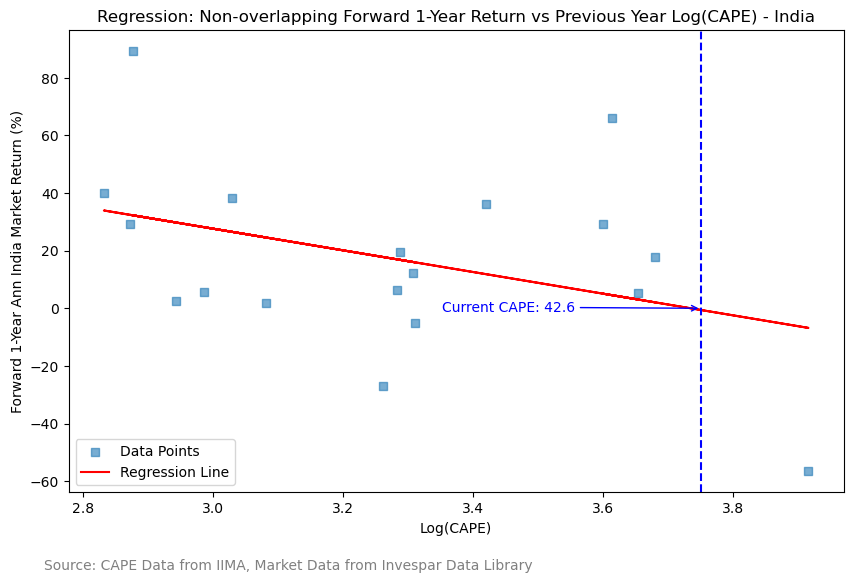

In [31]:

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot with square markers
ax.scatter(X, y * 100, alpha=0.6, label='Data Points', marker='s')

# Regression line
ax.plot(X, model_no_overlap.predict(X) * 100, color='red', label='Regression Line')

# Highlight current CAPE level
current_log_cape = np.log(merged_df['cape'].dropna().iloc[-1])
ax.axvline(x=current_log_cape, color='blue', linestyle='--')

# Annotate current CAPE level
ax.annotate(
    f"Current CAPE: {merged_df['cape'].dropna().iloc[-1]:.1f}", 
    xy=(current_log_cape, 0), 
    xytext=(current_log_cape -.4, -1), 
    arrowprops=dict(arrowstyle="->", color='blue'),
    fontsize=10,
    color='blue'
)

# Add labels, title, and legend
ax.set_xlabel('Log(CAPE)')
ax.set_ylabel('Forward 1-Year Ann India Market Return (%)')
ax.set_title('Regression: Non-overlapping Forward 1-Year Return vs Previous Year Log(CAPE) - India')
ax.legend()

# Add source annotation
source_text = "Source: CAPE Data from IIMA, Market Data from Invespar Data Library"
fig.text(0.1, -0.02, source_text, fontsize=10, color='gray')

# Show plot
plt.show()

## Conclusion and Observations

In this notebook, we demonstrated how to:

- Download Indian CAPE data and factor data.
- Merge different datasets to align dates.
- Compute a 1- and 5-year forward return from a monthly return series.
- Run a linear regression of forward returns against the log of CAPE.
- Explore non-overlappng period analysis

A *negative* coefficient $\beta_1$ would suggest that higher CAPE levels are associated with lower subsequent returns, aligning with many valuation-based theories. A *positive* coefficient would imply the opposite. Real-world data can be noisy, so it is useful to combine these findings with other research and practical considerations before arriving at conclusions.

We hope this exercise provides a illustration of how you can use publicly available datasets to conduct quantitative analyses of valuation metrics in the Indian equity markets.

## Further Considerations and Next Steps

While this notebook provides a foundational analysis of the relationship between the logarithm of CAPE and forward 5-year market returns, it is important to recognise that regression models rely on several underlying assumptions to ensure their validity and reliability. In this section, we highlight key considerations and suggest avenues for further exploration to enhance the robustness of our analysis.

1. **Assumptions of Linear Regression**

   Linear regression models are built upon several critical assumptions:

   ### Linearity
   The relationship between the independent variable (log(CAPE)) and the dependent variable (forward 5-year returns) is assumed to be linear. While our scatter plot and regression line suggest a linear trend, it is essential to verify this assumption formally. This could involve exploring non-linear models or adding polynomial terms if the relationship deviates from linearity.

   ### Independence of Errors
   The residuals (errors) are assumed to be independent of each other. The Durbin-Watson statistic is a test that indicates the presence of positive autocorrelation. Addressing autocorrelation might involve using time series models that account for such dependencies or incorporating lagged variables into the model.

   ### Homoskedasticity
   The assumption that residuals have constant variance across all levels of the independent variable can be tested using the Breusch-Pagan test. Ensuring homoskedasticity is crucial for the reliability of standard errors and hypothesis tests.

   ### Normality of Residuals
   The Shapiro-Wilk test examines whether the residuals are normally distributed. A violation of this assumption can impact the validity of confidence intervals and hypothesis tests. Potential remedies include transforming the dependent variable, using robust regression techniques, or applying non-parametric methods.

2. **Model Specification and Variable Selection**

   Our current model includes only the logarithm of CAPE as an explanatory variable. However, financial markets are influenced by a multitude of factors. Incorporating additional variables such as interest rates, macroeconomic indicators, or other valuation metrics could improve the model's explanatory power and provide a more nuanced understanding of the drivers behind market returns. It is important to ensure that not all variables are appropriate; for instance, inflation is one of the inputs in calculating CAPE. Using inflation-adjusted returns violates the assumption of independence between the dependent and explanatory variables, potentially leading to spurious results.

3. **Addressing Multicollinearity**

   If additional variables are introduced, it is crucial to assess multicollinearity to ensure that independent variables do not highly correlate with each other, which can distort coefficient estimates and inflate standard errors. Techniques such as Variance Inflation Factor (VIF) analysis can be employed to detect and mitigate multicollinearity.

4. **Robustness Checks and Validation**

   To ensure that findings are not specific to the chosen sample or time period, conducting robustness checks is advisable. This can include:

   - **Out-of-Sample Testing:**  
     Evaluating the model's performance on different time periods or subsets of the data to assess its generalisability.
   
   - **Alternative Specifications:**  
     Testing different model specifications, such as adding interaction terms or using alternative functional forms, to verify the consistency of the results.
   
   - **Cross-Validation:**  
     Implementing cross-validation techniques to prevent overfitting and to better estimate the model's predictive performance.


# References

1. Jacob, J. and Raju, R. (2024), Forecast or Fallacy? Shiller's CAPE: Market and Style Factor Forward Returns in Indian Equities. *SSRN eLibrary*, August, 27
2. Raju, R. (2022). Four and Five-Factor Models in the Indian Equities Market. *SSRN eLibrary*, March, 37
3. India CAPE Data sourced from [India CAPE (Cyclically Adjusted P/E)](https://capeindia.iima.ac.in/)
4. Factor Data sourced from [Invespar Data Library: Data Library: Fama-French Factors, Momentum, and Low-Risk Factors for the Indian Market](http://invespar.com/research).